In [2]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '.')
import streamlit as st

In [3]:
class DbConn:

    def __init__(self) -> None:
        self.conn = sqlite3.connect("../data/latest.db") 

    def execute_sql(self, query:str, params:dict = None, return_df:bool = True): 

        cur = self.conn.cursor() 
        try:
            if params is not None:
                cur.execute(query, params) 
            else:
                cur.execute(query) 
            if return_df:
                column_names = [col[0] for col in cur.description] 
                query_data = cur.fetchall() 
                query_df = pd.DataFrame.from_records(query_data, columns=column_names) 
                res = query_df 

            return res 
        finally:
            cur.close() 

    def commit(self):
        self.conn.commit() 
        self.conn.close() 

def getLvl1Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 1;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  

    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    return df

def getLvl2Data():
    
    conn = DbConn()

    query = f"""
            SELECT t.*,
                l.administrative_area_level,
                l.administrative_area_level_1,
                l.administrative_area_level_2,
                l.administrative_area_level_3,
                l.latitude,
                l.longitude,
                l.population
            FROM timeseries t 
            LEFT JOIN location l on l.id = t.id
            WHERE l.administrative_area_level = 2;
            """ 
    
    df = conn.execute_sql(query=query, return_df=True)  
    # Convert date column to datetime and get the date 
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    df['date'] = df['date'].apply(lambda x: pd.Timestamp(x).date())

    st.session_state['downloaded_lvl2_data'] = True

    return df


In [4]:
def epidemiological_features():
    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']
    return epidemiological_features 
    
def get_feature_time_series_lvl_1(df:pd.DataFrame, feature:str, administrative_area_level_1:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 1 and administrative_area_level_1 == @administrative_area_level_1')

    df = df[['date', feature]] 

    df['date'] = pd.to_datetime(df['date'])

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

def get_feature_time_series_lvl_2(df:pd.DataFrame, feature:str, administrative_area_level_2:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 2 and administrative_area_level_2 == @administrative_area_level_2')

    df = df[['date', feature]] 

    df = df.set_index('date')

    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df  

def get_feature_time_series_lvl_3(df:pd.DataFrame, feature:str, administrative_area_level_3:str):

    epidemiological_features = ['confirmed', 'deaths', 'recovered', 'tests', 'vaccines', 'people_vaccinated', 'people_fully_vaccinated', 'hosp']

    df = df.query('administrative_area_level == 3 and administrative_area_level_3 == @administrative_area_level_3')

    df = df[['date', feature]] 

    df = df.set_index('date')


    try:
        if df[feature].isnull().value_counts().iloc[1] > 0:
            df[feature] = df[feature].fillna(0) 

            return df 
    finally:
        return df 

## Dados

In [35]:
df = getLvl1Data() 
#dados confirmados brazil 

data = get_feature_time_series_lvl_1(df, feature='confirmed', administrative_area_level_1='Brazil')

In [36]:
data = data.reset_index()
data['confirmed'] = data['confirmed'].diff() 
data['confirmed'] = data['confirmed'].fillna(0)

In [37]:
data

,date,confirmed
0,2020-02-25,0.0
1,2020-02-26,0.0
2,2020-02-27,0.0
3,2020-02-28,1.0
4,2020-02-29,0.0
...,...,...
1118,2023-03-19,0.0
1119,2023-03-20,0.0
1120,2023-03-21,0.0
1121,2023-03-22,0.0


## Modelagem

#### StatsForecast Model

In [38]:
data['unique_id'] = '1' 
data.rename(columns={"date":"ds", "confirmed":"y"}, inplace=True)

In [39]:
data

,ds,y,unique_id
0,2020-02-25,0.0,1
1,2020-02-26,0.0,1
2,2020-02-27,0.0,1
3,2020-02-28,1.0,1
4,2020-02-29,0.0,1
...,...,...,...
1118,2023-03-19,0.0,1
1119,2023-03-20,0.0,1
1120,2023-03-21,0.0,1
1121,2023-03-22,0.0,1


In [73]:
data_no_trend = data.copy() 
data_no_trend['y'] = data_no_trend['y'].diff().fillna(0)

In [102]:
data_no_trend_variance = data_no_trend.copy()
data_no_trend_variance['y'] = data_no_trend['y'].diff(7).fillna(0)

In [103]:
data_no_trend_variance

,ds,y,unique_id
0,2020-02-25,0.0,1
1,2020-02-26,0.0,1
2,2020-02-27,0.0,1
3,2020-02-28,0.0,1
4,2020-02-29,0.0,1
...,...,...,...
1118,2023-03-19,0.0,1
1119,2023-03-20,0.0,1
1120,2023-03-21,0.0,1
1121,2023-03-22,0.0,1


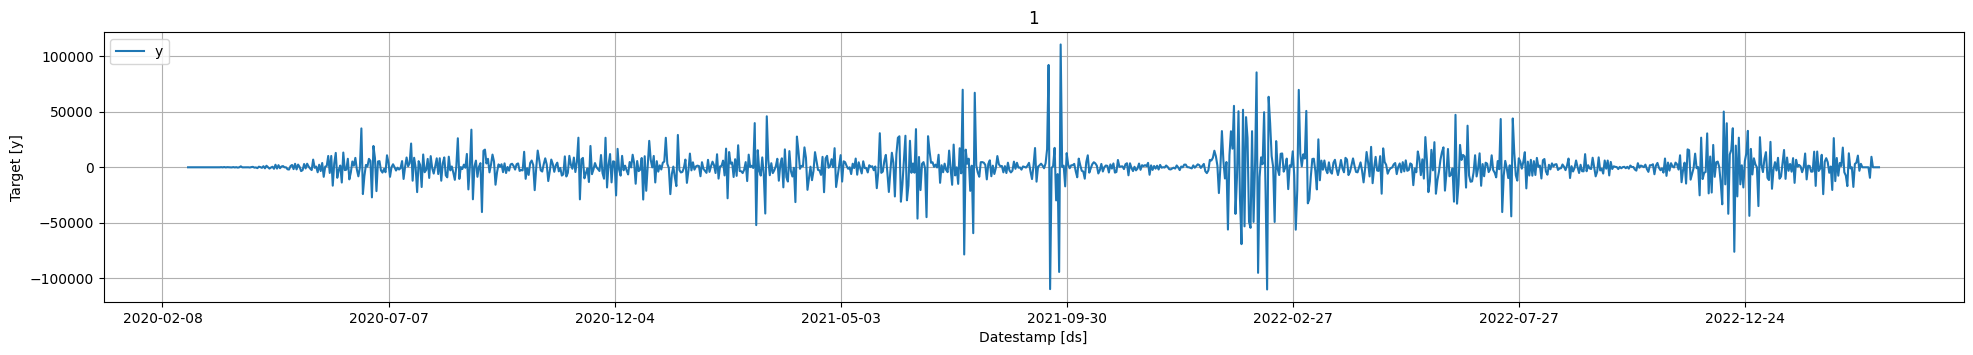

In [104]:
from statsforecast import StatsForecast

StatsForecast.plot(data_no_trend_variance)

### Split the data

In [105]:
def train_test_split(stationary_ts, proportion=80):
    train_size = int((proportion/100)*len(stationary_ts))
    train, test = stationary_ts[:train_size], stationary_ts[train_size:]

    print(train_size, (len(stationary_ts)-train_size))

    return train, test

In [107]:
train, test = train_test_split(data_no_trend_variance, 95)

1066 57


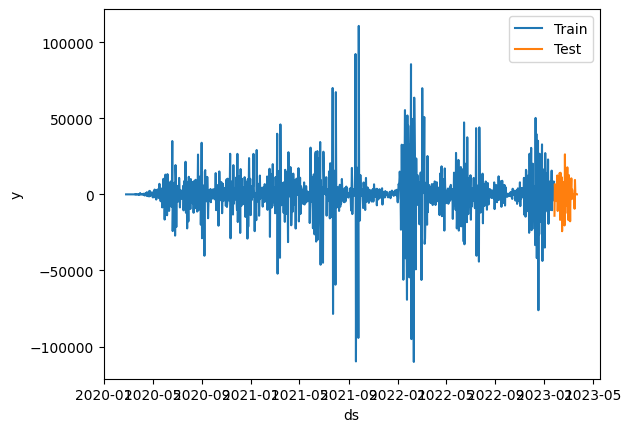

In [108]:
import seaborn as sns

sns.lineplot(train,x="ds", y="y", label="Train")
sns.lineplot(test, x="ds", y="y", label="Test")
plt.show()

In [109]:
from statsforecast.models import AutoRegressive

season_length = 7 #Weekly data 
horizon = len(test) 

models = [AutoRegressive(lags=[1,2,3,4,6,7,8,9,10,13,14], include_mean=False, alias="AR_no_trend_variance")]

In [110]:
sf = StatsForecast(
    df=train, 
    models=models,
    freq='D',
    n_jobs=-1
)

In [111]:
sf.fit()

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsforecast\arima.py:828: UserWarning: some AR parameters were fixed: setting transform_pars = False
  warnings.warn(


StatsForecast(models=[AR_no_trend_variance])

## Análise de Resíduos

In [112]:
result = sf.fitted_[0,0].model_ 
print(result.keys())

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'aicc', 'bic', 'xreg', 'lambda', 'x'])


In [113]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,0.000000
...,...
1061,8401.048876
1062,4316.756233
1063,-662.947754
1064,-2709.465399


C:\Users\heito\AppData\Local\Temp\ipykernel_35008\3494366740.py:13: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1]);


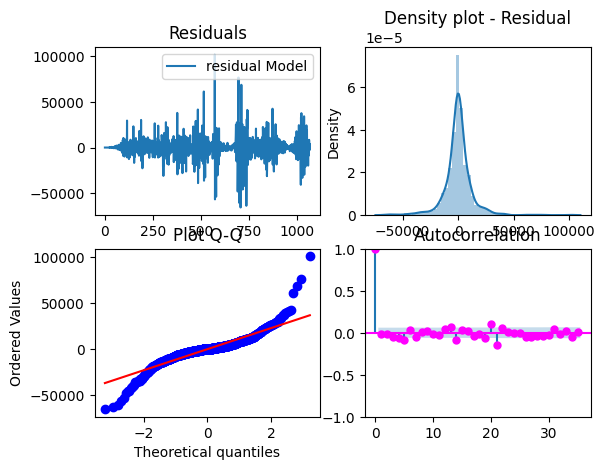

In [114]:
import scipy.stats as stats 
import statsmodels.api as sm 
import statsmodels.tsa.api as smt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

### Forecast Method

In [115]:
Y_hat = sf.forecast(horizon, fitted=True) 
Y_hat

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsforecast\arima.py:828: UserWarning: some AR parameters were fixed: setting transform_pars = False
  warnings.warn(


,ds,AR_no_trend_variance
unique_id,,
1,2023-01-26,-8844.938477
1,2023-01-27,5613.286133
1,2023-01-28,-4365.916504
1,2023-01-29,-716.745667
1,2023-01-30,3031.004395
1,2023-01-31,2293.742920
1,2023-02-01,-5699.187500
1,2023-02-02,1307.510864
1,2023-02-03,689.030151


In [116]:
values = sf.forecast_fitted_values() 
values.head()

,ds,y,AR_no_trend_variance
unique_id,,,
1,2020-02-25,0.0,0.0
1,2020-02-26,0.0,0.0
1,2020-02-27,0.0,0.0
1,2020-02-28,0.0,0.0
1,2020-02-29,0.0,0.0


In [117]:
sf.forecast(h=horizon, level=[95])

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsforecast\arima.py:828: UserWarning: some AR parameters were fixed: setting transform_pars = False
  warnings.warn(


,ds,AR_no_trend_variance,AR_no_trend_variance-lo-95,AR_no_trend_variance-hi-95
unique_id,,,,
1,2023-01-26,-8844.938477,-33244.597656,15554.721680
1,2023-01-27,5613.286133,-21394.775391,32621.347656
1,2023-01-28,-4365.916504,-31599.142578,22867.308594
1,2023-01-29,-716.745667,-27970.232422,26536.742188
1,2023-01-30,3031.004395,-24289.041016,30351.050781
1,2023-01-31,2293.742920,-25099.144531,29686.630859
1,2023-02-01,-5699.187500,-33133.761719,21735.384766
1,2023-02-02,1307.510864,-29003.283203,31618.304688
1,2023-02-03,689.030151,-30448.496094,31826.556641


In [118]:
Y_hat=Y_hat.reset_index()
Y_hat

,unique_id,ds,AR_no_trend_variance
0,1,2023-01-26,-8844.938477
1,1,2023-01-27,5613.286133
2,1,2023-01-28,-4365.916504
3,1,2023-01-29,-716.745667
4,1,2023-01-30,3031.004395
5,1,2023-01-31,2293.742920
6,1,2023-02-01,-5699.187500
7,1,2023-02-02,1307.510864
8,1,2023-02-03,689.030151
9,1,2023-02-04,-594.207520


In [119]:
# Merge the forecasts with the true values
test['unique_id'] = test['unique_id'].astype(int)
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

C:\Users\heito\AppData\Local\Temp\ipykernel_35008\254759652.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['unique_id'] = test['unique_id'].astype(int)


,ds,y,unique_id,AR_no_trend_variance
0,2023-01-26,-14051.0,1,-8844.938477
1,2023-01-27,6745.0,1,5613.286133
2,2023-01-28,697.0,1,-4365.916504
3,2023-01-29,2070.0,1,-716.745667
4,2023-01-30,762.0,1,3031.004395
5,2023-01-31,-4424.0,1,2293.742920
6,2023-02-01,-173.0,1,-5699.187500
7,2023-02-02,12427.0,1,1307.510864
8,2023-02-03,-10921.0,1,689.030151
9,2023-02-04,1448.0,1,-594.207520


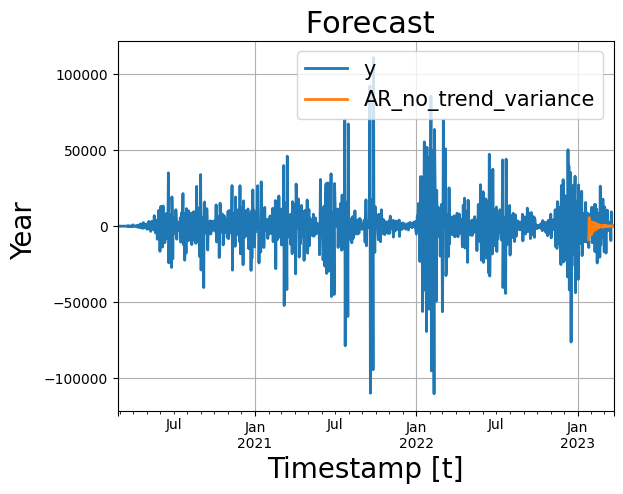

In [120]:
# Merge the forecasts with the true values

fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1]).set_index('ds')
plot_df[['y', "AR_no_trend_variance"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Year ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()

## Voltando a escala 

In [121]:
Y_hat1_original = Y_hat1.copy() 
Y_hat1_original['y'] = Y_hat1_original['y'].cumsum().cumsum()
Y_hat1_original['AR_no_trend_variance'] = Y_hat1_original['AR_no_trend_variance'].cumsum().cumsum()

In [124]:
train['y'] = train['y'].cumsum().cumsum()

C:\Users\heito\AppData\Local\Temp\ipykernel_35008\3609566702.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['y'] = train['y'].cumsum().cumsum()


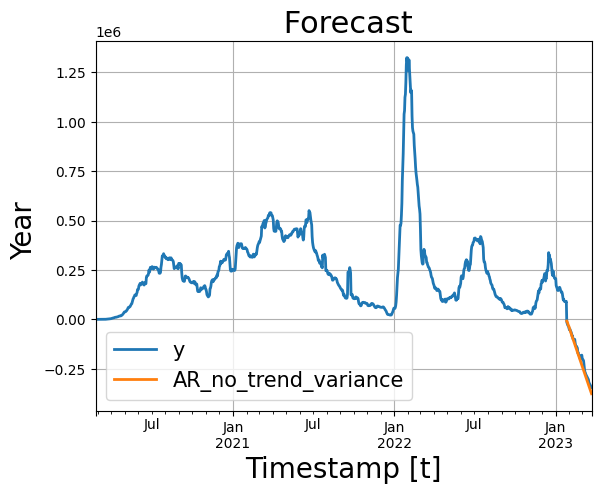

In [125]:
# Merge the forecasts with the true values

fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1_original]).set_index('ds')
plot_df[['y', "AR_no_trend_variance"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Year ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()

### AutoARIMA

In [128]:
from statsforecast.models import AutoARIMA 
from statsforecast.arima import arima_string

In [162]:
train, test = train_test_split(data, proportion=70)

786 337


In [163]:
season_length = 7 
horizon = len(test)

models = [AutoARIMA(season_length=season_length)]

In [164]:
sf = StatsForecast(df=train,
                   models=models,
                   freq='D', 
                   n_jobs=-1)

In [165]:
sf.fit()

StatsForecast(models=[AutoARIMA])

In [166]:
arima_string(sf.fitted_[0,0].model_)

'ARIMA(3,0,0)(2,1,0)[7]                   '

In [167]:
result=sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(3, 0, 2, 0, 7, 0, 1)


In [168]:
residual=pd.DataFrame(result.get("residuals"), columns=["residual Model"])
residual

,residual Model
0,0.000000e+00
1,0.000000e+00
2,0.000000e+00
3,9.999990e-04
4,-1.334075e-09
...,...
781,-7.585107e+03
782,7.967971e+03
783,5.777160e+03
784,-6.641349e+03


C:\Users\heito\AppData\Local\Temp\ipykernel_35008\3728362320.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(residual, ax=axs[0,1]);


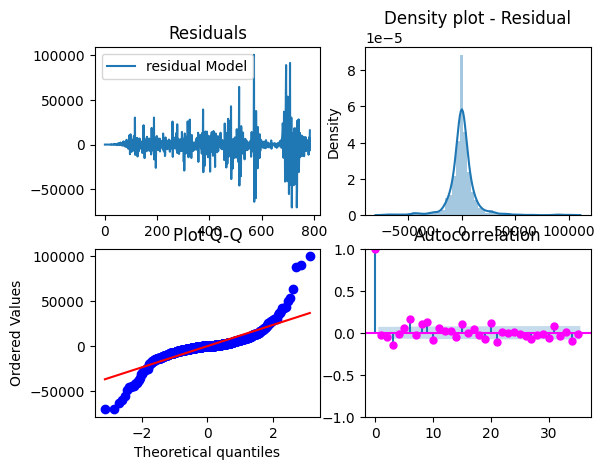

In [169]:
fig, axs = plt.subplots(nrows=2, ncols=2)

# plot[1,1]
residual.plot(ax=axs[0,0])
axs[0,0].set_title("Residuals");

# plot
sns.distplot(residual, ax=axs[0,1]);
axs[0,1].set_title("Density plot - Residual");

# plot
stats.probplot(residual["residual Model"], dist="norm", plot=axs[1,0])
axs[1,0].set_title('Plot Q-Q')

# plot
plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia")
axs[1,1].set_title("Autocorrelation");

plt.show();

In [170]:
Y_hat_df = sf.forecast(horizon, fitted=True)

Y_hat_df.head()

,ds,AutoARIMA
unique_id,,
1,2022-04-21,29134.695312
1,2022-04-22,21170.796875
1,2022-04-23,12468.731445
1,2022-04-24,6575.381348
1,2022-04-25,10893.489258


In [171]:
values=sf.forecast_fitted_values()
values

,ds,y,AutoARIMA
unique_id,,,
1,2020-02-25,0.0,0.000000e+00
1,2020-02-26,0.0,0.000000e+00
1,2020-02-27,0.0,0.000000e+00
1,2020-02-28,1.0,9.990000e-01
1,2020-02-29,0.0,1.334076e-09
...,...,...,...
1,2022-04-16,2775.0,1.036011e+04
1,2022-04-17,2541.0,-5.426971e+03
1,2022-04-18,8470.0,2.692840e+03


In [155]:
sf.forecast(h=12, level=[95])

,ds,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-hi-95
unique_id,,,,
1,2022-08-11,34423.546875,9018.029297,59829.062500
1,2022-08-12,28192.876953,-317.342712,56703.093750
1,2022-08-13,11940.287109,-17747.894531,41628.468750
1,2022-08-14,3632.771729,-27080.761719,34346.304688
1,2022-08-15,13678.391602,-17932.863281,45289.644531
1,2022-08-16,25777.166016,-6623.711914,58178.046875
1,2022-08-17,27426.976562,-5671.056152,60525.007812
1,2022-08-18,31585.957031,-7197.532227,70369.445312
1,2022-08-19,25057.173828,-15888.246094,66002.593750


In [172]:
Y_hat_df=Y_hat_df.reset_index()
Y_hat_df

,unique_id,ds,AutoARIMA
0,1,2022-04-21,29134.695312
1,1,2022-04-22,21170.796875
2,1,2022-04-23,12468.731445
3,1,2022-04-24,6575.381348
4,1,2022-04-25,10893.489258
...,...,...,...
332,1,2023-03-19,6322.752930
333,1,2023-03-20,10690.789062
334,1,2023-03-21,19383.189453
335,1,2023-03-22,34316.871094


C:\Users\heito\AppData\Local\Temp\ipykernel_35008\3986446186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['unique_id'] = test['unique_id'].astype(int)


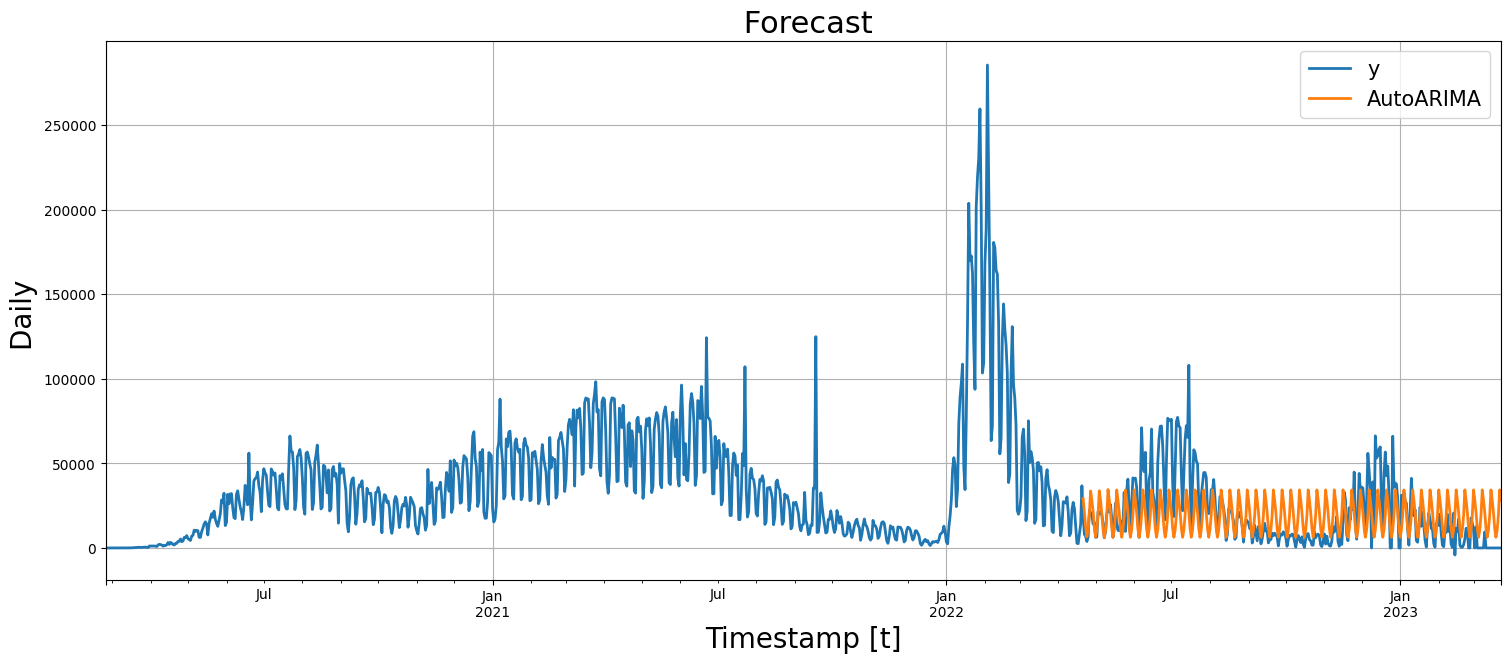

In [173]:
test['unique_id'] = test['unique_id'].astype(int)
Y_hat_df = test.merge(Y_hat_df, how='left', on=['unique_id', 'ds'])

fig, ax = plt.subplots(1, 1, figsize = (18, 7))
plot_df = pd.concat([train, Y_hat_df]).set_index('ds')
plot_df[['y', 'AutoARIMA']].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Daily ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

### AR Model

In [466]:
train, test = train_test_split(data, proportion=60)

673 450


In [ ]:
def AutoRegressiveModel(train: pd.Series, lags: list[int] | None, max_lags: int | None = None):
    if lags is None:
        # Realiza seleção automática de Lags
        selector = ar_select_order(train)
        # Additional logic for automatic lag selection
    else:
        if max_lags is not None:
            # Handle max_lags when lags is not None
            # Additional logic for when lags is provided and max_lags is specified
            print(f'Max Lags: {max_lags}')
        else:
            # Handle case when max_lags is not specified
            # Additional logic for when lags is provided without max_lags
            print('Max Lags not specified')

In [467]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order, AutoRegResults

selector = ar_select_order(train['y'], 15)
ar_model = AutoReg(train['y'], lags=selector.ar_lags, seasonal=True, period=7).fit()

In [468]:
ar_model.test_normality()

Jarque-Bera    22651.625431
P-value            0.000000
Skewness           2.609036
Kurtosis          31.266072
dtype: float64

In [456]:
forecasts = ar_model.forecast(steps=len(test))

In [457]:
import plotly.graph_objects as go
def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    # fig.add_trace(go.Scatter(x=train['ds'], y=train['y'], name='Train'))
    fig.add_trace(go.Scatter(x=test['ds'], y=test['y'], name='Test'))
    fig.add_trace(go.Scatter(x=test['ds'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title=' Confirmados')

    return fig.show()

## Residuals

In [222]:
residuals = pd.DataFrame(ar_model.resid) 
residuals.columns = ['residuals']

In [250]:
residuals

,residuals
15,-1955.471071
16,-3084.533824
17,-3459.370105
18,-1126.355946
19,4446.291611
...,...
1061,-111.848044
1062,5430.642705
1063,4337.809826
1064,-5174.299594


In [458]:
# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

In [232]:
from statsmodels.graphics.gofplots import qqplot

def residual_analysis(residual:pd.DataFrame):

    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,10))

    # plot[1,1]
    residual.plot(ax=axs[0,0])
    axs[0,0].set_title("Residuals");

    # plot
    sns.distplot(residual, ax=axs[0,1]);
    axs[0,1].set_title("Density plot - Residual");

    # # plot
    qqplot(residuals['residuals'], line='q', fit=True, ax=axs[1,0])
    axs[1,0].set_title('Plot Q-Q')

    # plot
    plot_acf(residual,  lags=35, ax=axs[1,1],color="fuchsia", auto_ylims=True)
    axs[1,1].set_title("Autocorrelation");

    plt.show()

C:\Users\heito\AppData\Local\Temp\ipykernel_35008\3640003526.py:12: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




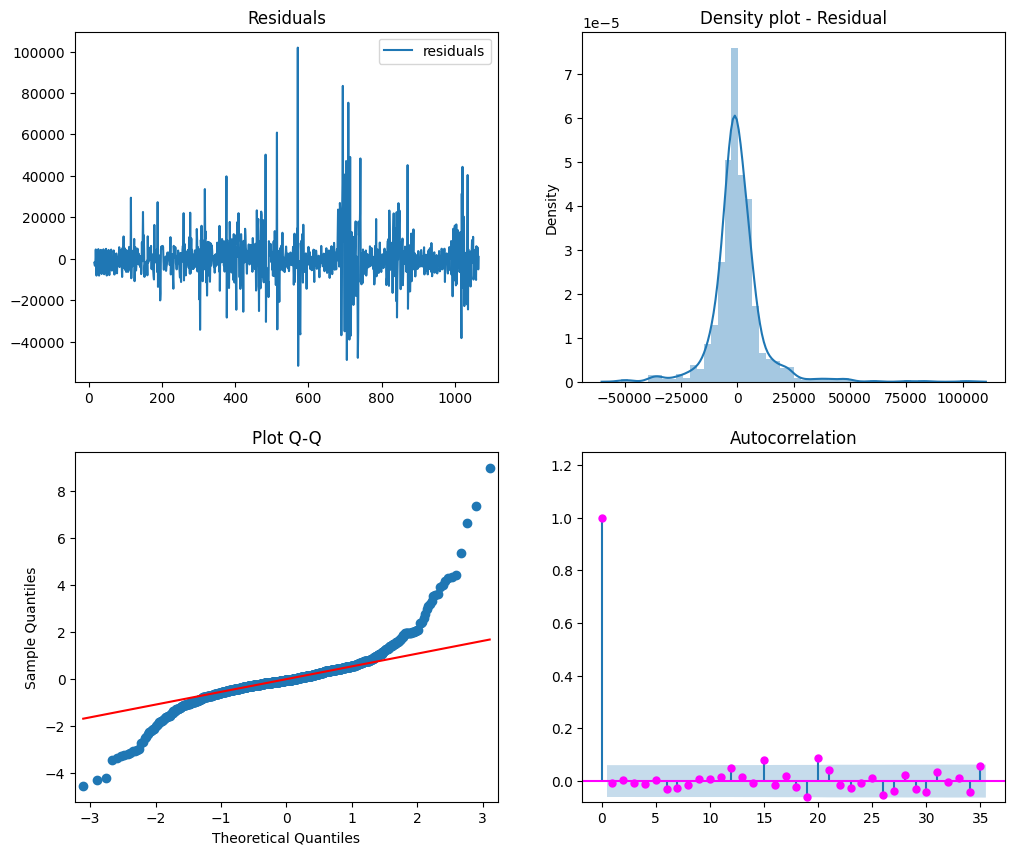

In [233]:
residual_analysis(residuals)

### Differencer from sktime

In [287]:
from sktime.transformations.series.difference import Differencer
from sktime.transformations.compose import InvertTransform


def apply_transformations(data:pd.Series):

    transformer1 = Differencer(lags=1) 
    transformer2 = Differencer(lags=7)         

    y_transform_1 = transformer1.fit_transform(data)
    y_transform_2 = transformer2.fit_transform(y_transform_1)         

    return y_transform_2

def revert_transformations(transformed_data:pd.Series):

    transformer1 = Differencer(lags=1) 
    transformer2 = Differencer(lags=7)  

    inverse_transform_1 = InvertTransform(transformer1)
    inverse_transform_2 = InvertTransform(transformer2)  

    y_transform_2_inverse = inverse_transform_2.fit_transform(transformed_data) 
    y_transform_1_inverse = inverse_transform_1.fit_transform(y_transform_2_inverse) 

    original_y = y_transform_1_inverse 

    return original_y 

## AR Model - Statsmodels - Agora VAI

### Trabalhando sem diferenciar antes - Usando as funcoes de tendencia da serie

In [420]:
# Build AR model
selector = ar_select_order(train['y'], maxlag=15)
model = AutoReg(train['y'], trend='t', seasonal=True, period=7, lags=selector.ar_lags).fit()

In [421]:
transformed_forecasts = model.forecast(steps=len(test))

In [422]:
test['forecast_ar'] = list(transformed_forecasts)

C:\Users\heito\AppData\Local\Temp\ipykernel_35008\2647230292.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<Axes: >

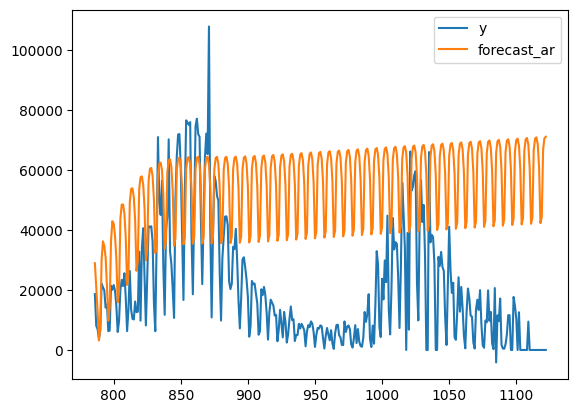

In [423]:
test[['y', 'forecast_ar']].plot()

### AR Nixtla


In [425]:
#Nixtla models 
model_ar = [AutoRegressive(lags=[1,2,3,4,5,6,7,8,9,10,11,12,13,14], include_mean=True)] 

sf = StatsForecast(
    df=train,
    models=model_ar,
    freq='D',
    n_jobs=-1
) 

sf.fit()

StatsForecast(models=[AutoRegressive])

In [426]:
Y_hat = sf.forecast(horizon, fitted=True)

In [429]:
values=sf.forecast_fitted_values()
values

,ds,y,AutoRegressive
unique_id,,,
1,2020-02-25,0.0,13188.932617
1,2020-02-26,0.0,3506.985107
1,2020-02-27,0.0,3880.910645
1,2020-02-28,1.0,3122.714600
1,2020-02-29,0.0,2562.214600
...,...,...,...
1,2022-04-16,2775.0,12761.465820
1,2022-04-17,2541.0,677.641724
1,2022-04-18,8470.0,6355.486816


In [431]:
test.drop(columns="forecast_ar", inplace=True)

C:\Users\heito\AppData\Local\Temp\ipykernel_35008\94544853.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [432]:
Y_hat1 = test.merge(Y_hat, how='left', on=['unique_id', 'ds'])
Y_hat1

,ds,y,unique_id,AutoRegressive
0,2022-04-21,18660.0,1,26600.689453
1,2022-04-22,8068.0,1,15575.872070
2,2022-04-23,6957.0,1,9714.447266
3,2022-04-24,3809.0,1,8455.035156
4,2022-04-25,6456.0,1,12129.755859
...,...,...,...,...
332,2023-03-19,0.0,1,38594.457031
333,2023-03-20,0.0,1,38567.394531
334,2023-03-21,0.0,1,38539.273438
335,2023-03-22,0.0,1,38530.597656


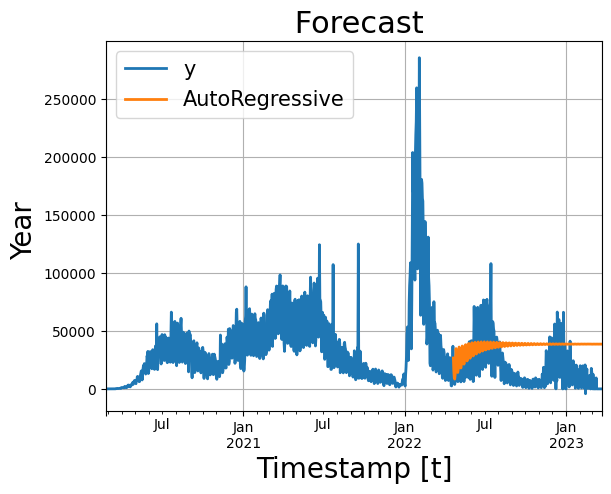

In [433]:
# Merge the forecasts with the true values

fig, ax = plt.subplots(1, 1)
plot_df = pd.concat([train, Y_hat1]).set_index('ds')
plot_df[['y', "AutoRegressive"]].plot(ax=ax, linewidth=2)
ax.set_title(' Forecast', fontsize=22)
ax.set_ylabel('Year ', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid(True)
plt.show()

### ChatGPT Model

In [434]:
train, test = train_test_split(data)

898 225


1010 113


c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.



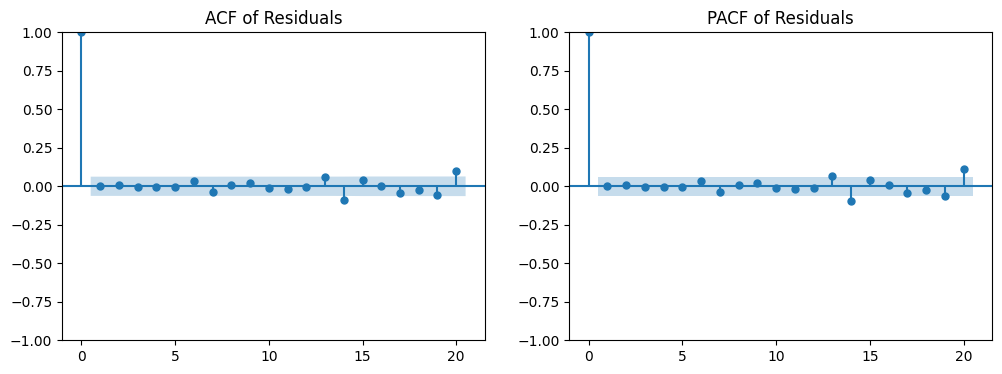

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



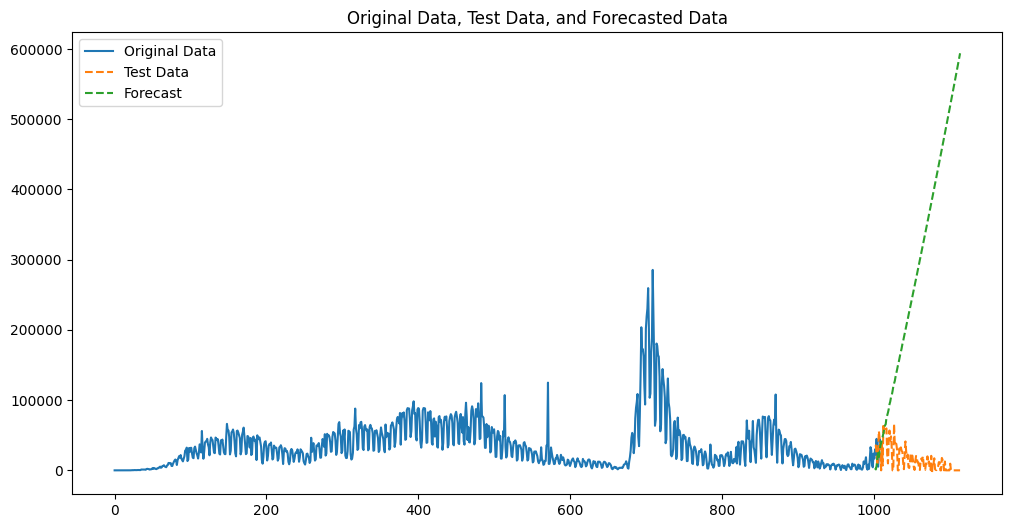

In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Step 1: Generate or load time series data
# Replace this with your actual time series data
train, test = train_test_split(data, proportion=90)

# Apply differencing
lag1_diff = train['y'].diff(1)
lag7_diff = lag1_diff.diff(7).dropna()  # Drop NaN values introduced by the second differencing

# Step 2: Fit an autoregressive (AR) model
order = 15  # Choose the order for the AR model
model = AutoReg(lag7_diff, lags=order)
results = model.fit()

# Step 3: Residual analysis
residuals = results.resid

# Plot ACF and PACF of residuals
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=ax1, lags=20, title='ACF of Residuals')
plot_pacf(residuals, ax=ax2, lags=20, title='PACF of Residuals')
plt.show()

# Step 4: Forecast and plot results in the original scale
test_data = test  # Replace with actual test data

# Forecast using the AR model
forecast = results.predict(start=len(lag7_diff), end=len(lag7_diff) + len(test) - 1)

# Invert the differencing to get forecasts in the original scale
forecast_original_scale = forecast.cumsum().cumsum() + lag1_diff.iloc[-7]

# Plot the original data, test data, and forecasted data
plt.figure(figsize=(12, 6))
plt.plot(train['y'], label='Original Data')
plt.plot(np.arange(len(lag7_diff), len(lag7_diff) + len(test)), test_data['y'], label='Test Data', linestyle='--')
plt.plot(np.arange(len(lag7_diff), len(lag7_diff) + len(test)), forecast_original_scale, label='Forecast', linestyle='--')
plt.title('Original Data, Test Data, and Forecasted Data')
plt.legend()
plt.show()

### Ajustando um AR com Intervalo de Confiança

In [607]:
train, test = train_test_split(data, proportion=90)

1010 113


In [661]:
#Modelo AR
from typing import Union, Optional

def AutoRegressiveModel(train: pd.Series, steps, lags: Optional[Union[list[int], int]]=None, max_lags: Optional[int | None] = None):
    if lags is None:
        if max_lags is None:
            raise ValueError("argumento `max_lags` não pode ser vazio quando `lags` é vazio")
        # Realiza seleção automática de Lags
        selector = ar_select_order(train, maxlag=max_lags)
        ar_model = AutoReg(train, lags=selector.ar_lags)
        ar_model_fit = ar_model.fit()

        # Get forecast and confidence intervals
        forecast_results = ar_model_fit.get_prediction(start=len(train), end=len(train) + steps - 1, dynamic=False)
        forecast_values = forecast_results.predicted_mean
        confidence_intervals = forecast_results.conf_int()

        return forecast_values, confidence_intervals

    else:
        if max_lags is not None:
            raise ValueError("O argumento `max_lags` deve ser usado apenas quando o argumento `lags` não é especificado")
        else:
            ar_model = AutoReg(train, lags=lags)
            ar_model_fit = ar_model.fit() 

            # Get forecast and confidence intervals
            forecast_results = ar_model_fit.get_prediction(start=len(train), end=len(train) + steps - 1, dynamic=False)
            forecast_values = forecast_results.predicted_mean
            confidence_intervals = forecast_results.conf_int()

            return forecast_values, confidence_intervals

In [662]:
forecast, ci = AutoRegressiveModel(train['y'], steps=len(test), max_lags=15)

In [663]:
def plot_test_data_forecast(test, forecasts, conf_int):
    # Plot the test data against the forecasted values
    plt.plot(np.arange(len(test)), test, label='Test Data', linestyle='--')
    plt.plot(np.arange(len(test)), forecasts, label='Forecast')
    plt.fill_between(np.arange(len(test)),
                    conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='gray', alpha=0.2, label='Confidence Interval')
    plt.legend()
    plt.show() 

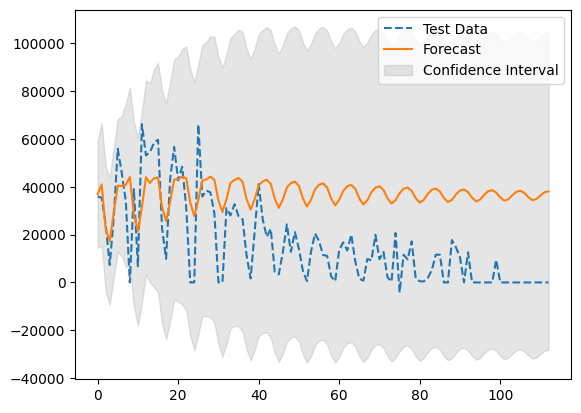

In [664]:
plot_test_data_forecast(test['y'], forecast, ci)

### Ajustando um MA 

In [544]:
def plot_forecasts(forecasts: list[float],
                   conf_int: list[list[float]],
                   title: str) -> None:
    """Function to plot the forecasts with confidence interval."""
    upper_bound = conf_int[:, 1]
    lower_bound = conf_int[:, 0]

    fig = go.Figure()

    # Add the test data
    fig.add_trace(go.Scatter(x=test['ds'], y=test['stationary'], name='Test'))

    # Add the forecast
    fig.add_trace(go.Scatter(x=test['ds'], y=forecasts, name='Forecast'))

    # Add the confidence interval
    fig.add_trace(go.Scatter(x=test['ds'] + test['ds'], y=upper_bound + lower_bound[::-1],
                             fill='toself', fillcolor='rgba(0,100,80,0.2)',
                             line=dict(color='rgba(255,255,255,0)'),
                             name='Confidence Interval'))

    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Confirmados')

    return fig.show()

In [484]:
train, test = train_test_split(data, proportion=90)

1010 113


In [665]:
train['stationary'] = train['y'].diff().fillna(0) 
test['stationary'] = test['y'].diff().fillna(0)

C:\Users\heito\AppData\Local\Temp\ipykernel_35008\2942005338.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\heito\AppData\Local\Temp\ipykernel_35008\2942005338.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [671]:
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

def MovingAverageModel(train:pd.Series, q:int, steps:int):
    ma_model = ARIMA(endog=train, order=(0,0,q)).fit() 

    #Forecasts 
    forecasts = ma_model.get_forecasts(steps=steps) 
    forecast_values = forecasts.predicted_mean 
    forecast_conf_int = forecasts.conf_int() 
    
    return forecast_values, forecast_conf_int 

In [675]:
ar= MovingAverageModel(train['y'], q=15) 

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [676]:
forecasts = ar.get_forecast(steps=len(test))

In [677]:
forecast_values = forecasts.predicted_mean 
conf_int = forecasts.conf_int()

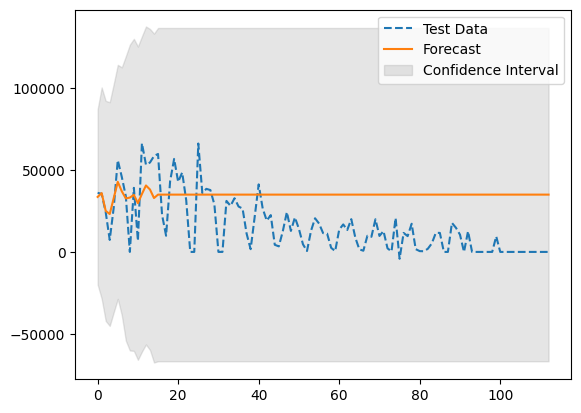

In [678]:
plot_test_data_forecast(test['y'], forecasts=forecast_values, conf_int=conf_int)

## Ajustando um ARIMA

In [697]:
from pmdarima.arima import auto_arima 
from typing import Optional

def ARIMAModel(train: pd.Series, steps:int, p: Optional[int] = None, d: Optional[int] = None, q: Optional[int] = None, auto: bool = False):

    if auto:
        auto_arima_model = auto_arima(train, alpha=0.05, stepwise=True, n_jobs=-1)
        model_order = auto_arima_model.order 
        auto_arima_model_fit = auto_arima_model.fit(train) 

        # Forecast future values (adjust the forecast horizon as needed)
        forecast, conf_int = auto_arima_model_fit.predict(n_periods=steps, return_conf_int=True)
        conf_int = pd.DataFrame(conf_int) 
        
        return forecast, conf_int, model_order
    
    arima_model_fit = ARIMA(train, order=(p,d,q)).fit() 

    #Forecasts 
    forecasts = arima_model_fit.get_forecast(steps=steps) 
    forecast_values = forecasts.predicted_mean 
    forecast_conf_int = forecasts.conf_int() 
    
    return forecast_values, forecast_conf_int

In [702]:
auto_arima_forecasts, auto_arima_conf_int = ARIMAModel(train=train['y'], steps=len(test), p=5, d=1, q=5)

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



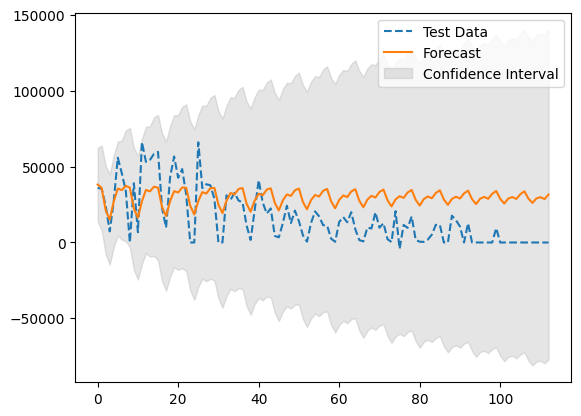

In [703]:
plot_test_data_forecast(test['y'], auto_arima_forecasts, auto_arima_conf_int)

### Ajustando um ARMA

In [679]:
def ARMAModel(train:pd.Series, p:int, q:int):
    arma_model = ARIMA(endog=train, order=(p,0,q)).fit() 
    return arma_model 

In [680]:
arma_model = ARMAModel(train['y'], p=5, q =5)

c:\Users\heito\OneDrive\Documentos\Estudos\becd\07sem\SME0808 - series-temporais\time-series\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [686]:
forecasts = arma_model.get_forecast(steps=len(test))